In [16]:
import os
import re
import numpy as np

def retrieve_fidelity_dict(base_dir):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    
    # Iterate through each subfolder in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]
            # Path to the cost.txt file
            cost_file_path = os.path.join(folder_path, 'fidelity.txt')
            
            # Read the cost value from the cost.txt file
            if os.path.exists(cost_file_path):
                    with open(cost_file_path, 'r') as file:
                        # Extract the complex number part using regular expression
                        complex_str = file.read().strip()
                        # Convert the extracted string to a complex number
                        complex_number = complex(complex_str)
                        # Get the real part and convert to float
                        float_value = complex_number.real
                        if prefix not in fidelity_dict:
                            fidelity_dict[prefix] = []
                        fidelity_dict[prefix].append(abs(float_value))
    
    return fidelity_dict

# Define the base directory where the folders are located
base_directory = 'experiment_result'

# Retrieve costs and convert to matrix
fidelity_dict_rho_rho3 = retrieve_fidelity_dict(base_directory)


In [17]:
import tensorflow as tf
import numpy as np
import re
import epsilon_rho
import metrics

# Function to read and parse the tensor data from a text file
def parse_tensor_from_file(file_path, shape):
    with open(file_path, 'r') as file:
        # Read the content of the file
        tensor_str = file.read()
        # Regular expression to match complex numbers
        # The pattern captures real and imaginary parts
        pattern = r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?'

        # Find all matches in the string
        matches = re.findall(pattern, tensor_str)

    # Convert string to a NumPy array
    numpy_tensor = np.array(matches, dtype=np.complex128)
    if (shape == 3):
        numpy_tensor = numpy_tensor.reshape(round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)))
    if (shape == 2):
         numpy_tensor = numpy_tensor.reshape(round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)))
    # Convert NumPy array to TensorFlow tensor
    tf_tensor = tf.convert_to_tensor(numpy_tensor)

    return tf_tensor

from qoop.core import state, ansatz, metric
from qiskit.quantum_info import DensityMatrix
def retrieve_fidelity_dict_from_tensor(base_dir):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)

        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]

            kraus_file_path = os.path.join(folder_path, 'kraus_operators.txt')
            kraus_operators = parse_tensor_from_file(kraus_file_path, 3)

            rho2_file_path = os.path.join(folder_path, 'rho2.txt')
            rho2 = parse_tensor_from_file(rho2_file_path, 2)
            
            rho_file_path = os.path.join(base_dir, prefix+'_qubits_rho.txt')
            rho= parse_tensor_from_file(rho_file_path, 2)

            out_rho2 = epsilon_rho.calculate_from_kraus_operators(rho=rho, kraus_operators=kraus_operators)
            out_rho2 = np.transpose(np.conjugate(out_rho2))
            
            fildelity = abs(1 - metrics.compilation_trace_fidelity(rho2, out_rho2))
            if prefix not in fidelity_dict:
                fidelity_dict[prefix] = []
            fidelity_dict[prefix].append((fildelity))

    return fidelity_dict

fidelity_dict_rho_rho2 = retrieve_fidelity_dict_from_tensor('experiment_result')



In [18]:
import matplotlib.pyplot as plt

def plot_fidelity (fidelity_dict, ylabel, file_name):
    # Plotting
    plt.figure(figsize=(10, 6))

    colorList = ['r', 'g', 'b', 'magenta', 'orange']
    # Plot each category
    i = 0
    for key, values in fidelity_dict.items():
        color = colorList[i]
        i = i + 1
        plt.plot(values, label=key, color = color)
    
    # Adding title and labels
    plt.xlabel('Gamma')
    plt.ylabel(ylabel)

    plt.yscale('log')  # Set y-axis to logarithmic scale
    # Customizing x-axis ticks
    x_ticks = np.arange(0, 20, step=2)  # Adjust step size based on your data
    x_tick_labels = [f'{tick/20:.2f}' for tick in x_ticks]  # Convert to float and format
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    
    plt.savefig('docs/'+file_name+'.png', format='png')
    plt.savefig('docs/'+file_name+'.eps', format='eps')
    plt.legend()

    # Display the plot
    plt.show()
    

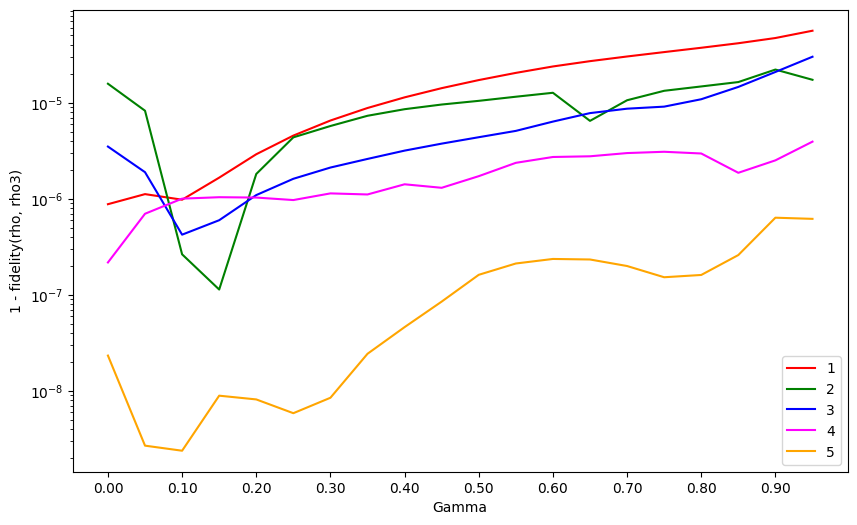

In [19]:
plot_fidelity(fidelity_dict_rho_rho3, '1 - fidelity(rho, rho3)', 'output_rho-rho3')

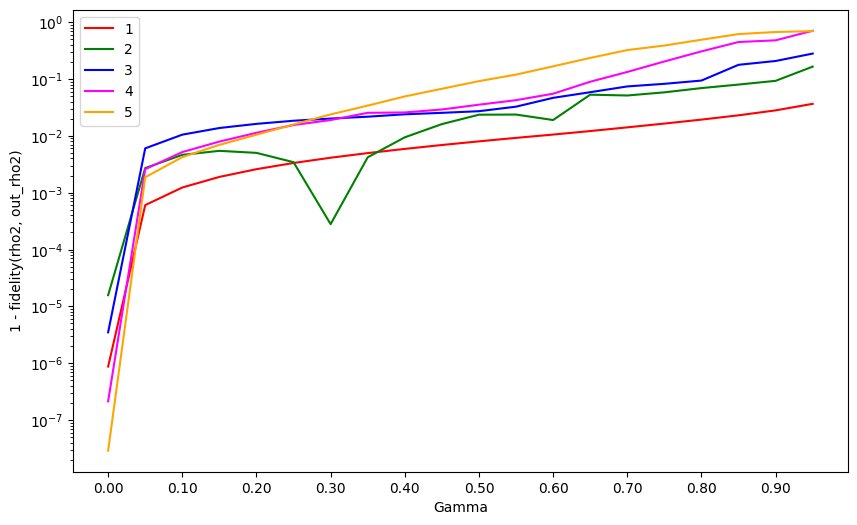

In [20]:
plot_fidelity(fidelity_dict_rho_rho2, '1 - fidelity(rho2, out_rho2)', 'output_rho2-out_rho2')

In [13]:
import epsilon_rho
import init

def retrieve_Z_dict(base_dir):
     # Iterate through each subfolder in the base directory
     Z_dict = {}

     for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
          # Path to the cost.txt file
          parts = folder_path.split('_')  # Split by underscore
          postfix = parts[-1]  # Get the last part
          
          rho2_file_path = os.path.join(folder_path, 'tr_rho2.txt')
          out_rho2_file_path = os.path.join(folder_path, 'tr_out_rho2.txt')
          with open(rho2_file_path, 'r') as file:
               # Extract the complex number part using regular expression
               str_rho2 = file.read().strip()
               # Convert the extracted string to a complex number
               num_rho2 = float(str_rho2)

          with open(out_rho2_file_path, 'r') as file:
               # Extract the complex number part using regular expression
               str_out_rho2 = file.read().strip()
               # Convert the extracted string to a complex number
               num_out_rho2 = float(str_out_rho2)

          if postfix+'_rho2' not in Z_dict:
               Z_dict[postfix+'_rho2'] = []
          if postfix+'_out' not in Z_dict:
               Z_dict[postfix+'_out'] = []     
          Z_dict[postfix+'_rho2'].append((num_rho2))
          Z_dict[postfix+'_out'].append((num_out_rho2))
     return Z_dict





In [ ]:
def plot_Z (fidelity_dict, ylabel, file_name):
    # Plotting
    plt.figure(figsize=(10, 6))

    colorList = ['r', 'g', 'b', 'magenta', 'orange']
    # Plot each category
    i = 0
    for key, values in fidelity_dict.items():
        color = colorList[i]
        i = i + 1
        plt.plot(values, label=key, color = color)
    
    # Adding title and labels
    plt.xlabel('Time')
    plt.ylabel(ylabel)

    # Customizing x-axis ticks
    x_ticks = np.arange(0, 20, step=1)  # Adjust step size based on your data
    x_tick_labels = [f'{tick}' for tick in x_ticks]  # Convert to float and format
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    
    plt.savefig('docs/'+file_name+'.png', format='png')
    plt.savefig('docs/'+file_name+'.eps', format='eps')
    plt.legend()

    # Display the plot
    plt.show()



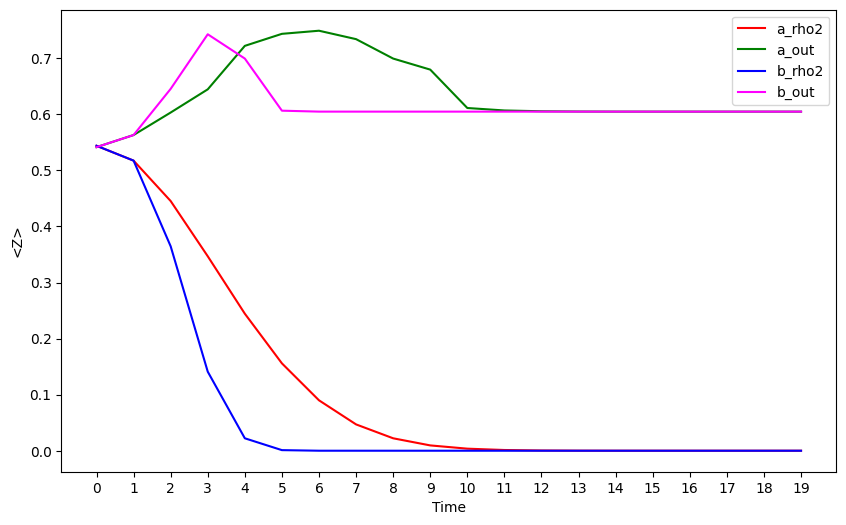

In [22]:
Z_dict = retrieve_Z_dict('experiment_trace_Z/1')
plot_Z(Z_dict, '<Z>', 'Z_1')